In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

2.14.0


In [12]:
file_path = 'Dataset_Path'
data = pd.read_csv(file_path)

In [13]:
data.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,NaN,NaN,NaN,NaN


In [14]:
min_year = data['JAHR'].min()
max_year = data['JAHR'].max()

print(f"Minimum year in the dataset: {min_year}")
print(f"Maximum year in the dataset: {max_year}")

Minimum year in the dataset: 2000
Maximum year in the dataset: 2023


In [15]:
year = 2021
month = 1

In [16]:
data['MONAT'] = data['MONAT'].astype(str).str[:6]
data['MONAT'] = pd.to_datetime(data['MONAT'], format='%Y%m')
# data = data[data['JAHR'] <= 2020]

cutoff_date = pd.to_datetime(f"{year}{month:02d}", format='%Y%m')
filtered_data = data[(data['MONATSZAHL'] == 'Alkoholunfälle') & (data['AUSPRAEGUNG'] == 'insgesamt') & (data['MONAT'] < cutoff_date)]

In [17]:
data.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,2023-01-01,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,2023-02-01,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,2023-03-01,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,2023-04-01,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,2023-05-01,NaN,NaN,NaN,NaN,NaN


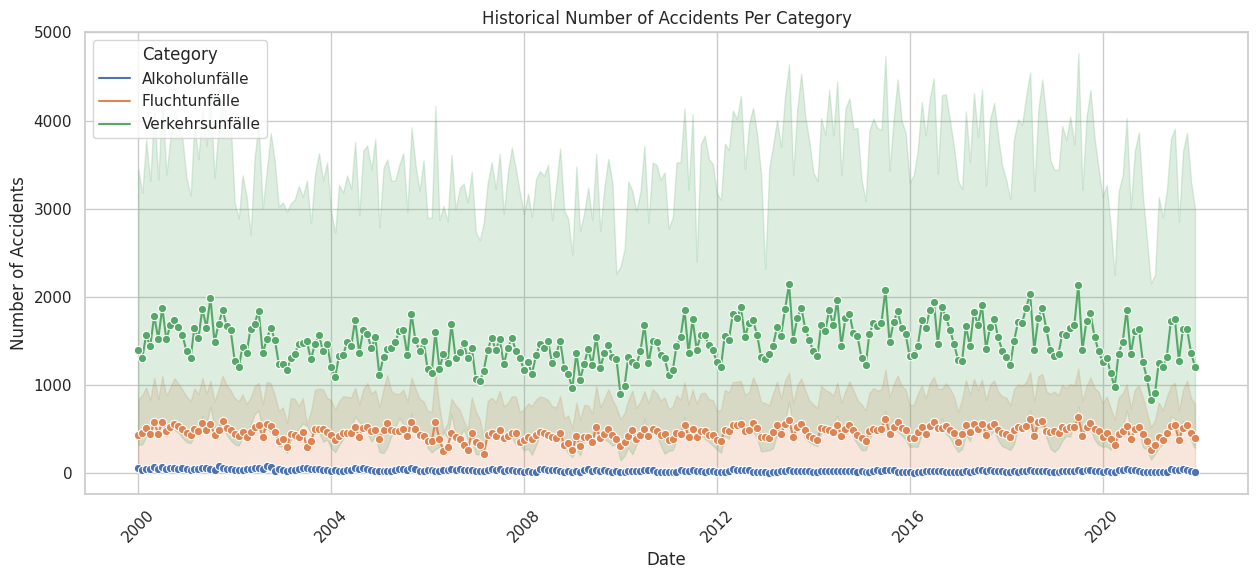

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x='MONAT', y='WERT', hue='MONATSZAHL', data=data, marker='o')
plt.title('Historical Number of Accidents Per Category')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Category', loc='upper left')
plt.show()

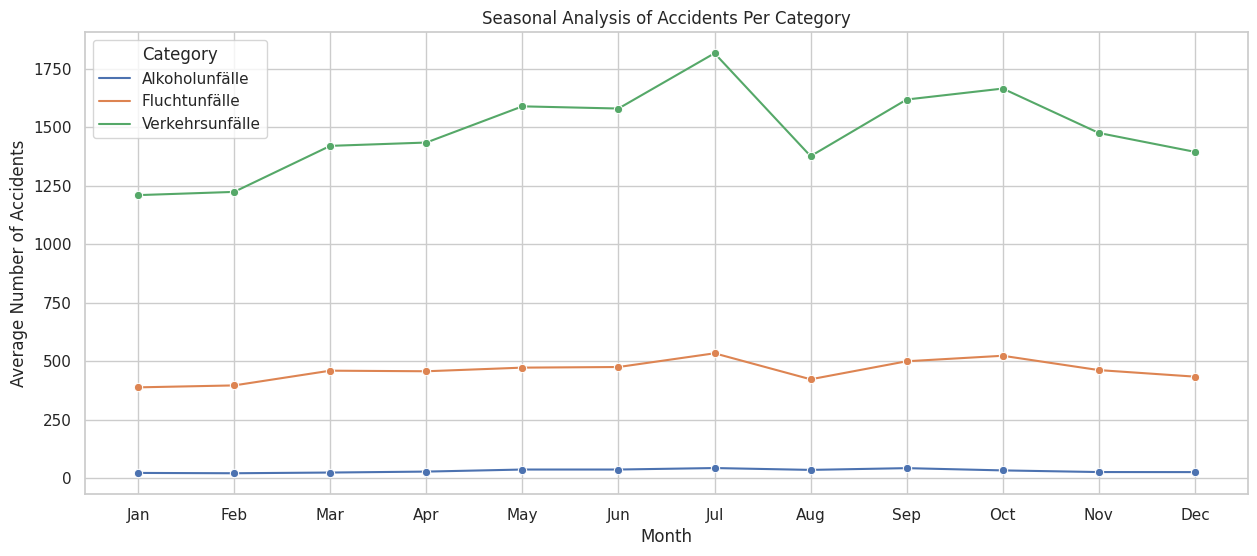

In [19]:
# Seasonal Analysis
monthly_data = data.groupby(['MONATSZAHL', data['MONAT'].dt.month])['WERT'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(x='MONAT', y='WERT', hue='MONATSZAHL', data=monthly_data, marker='o')
plt.title('Seasonal Analysis of Accidents Per Category')
plt.xlabel('Month')
plt.ylabel('Average Number of Accidents')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Category', loc='upper left')
plt.show()

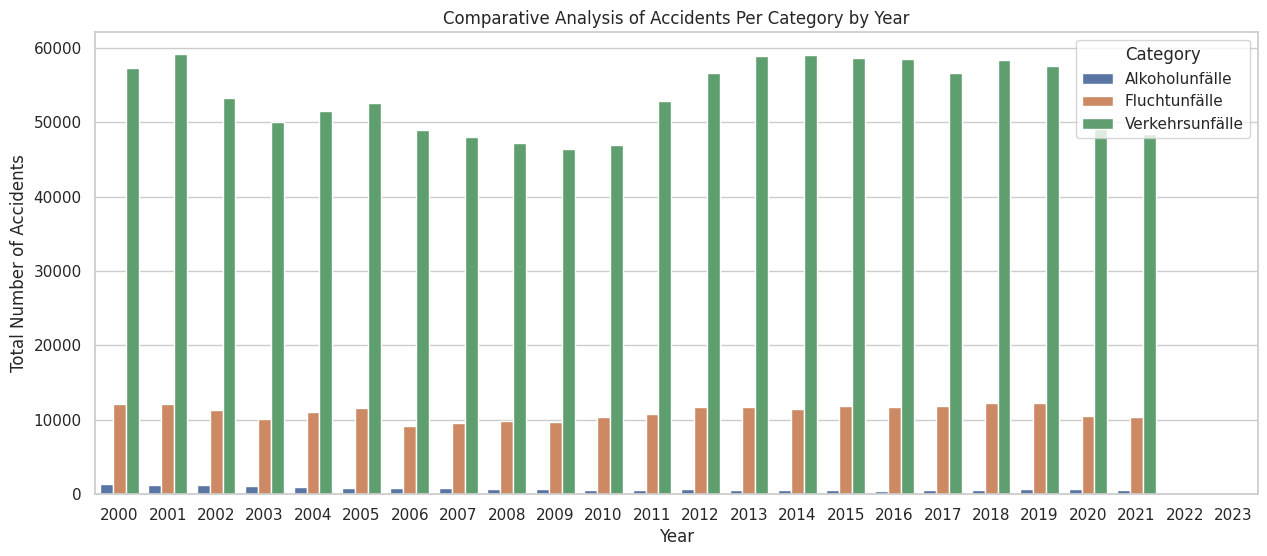

In [20]:
yearly_data = data.groupby(['MONATSZAHL', 'JAHR'])['WERT'].sum().reset_index()
plt.figure(figsize=(15, 6))
sns.barplot(x='JAHR', y='WERT', hue='MONATSZAHL', data=yearly_data)
plt.title('Comparative Analysis of Accidents Per Category by Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Accidents')
plt.legend(title='Category', loc='upper right')
plt.show()

In [21]:
filtered_data['UNIX_MONAT'] = filtered_data['MONAT'].apply(lambda x: x.timestamp())

X = filtered_data['UNIX_MONAT'].values.reshape(-1, 1)
y = filtered_data['WERT'].values

<ipython-input-21-24ecfef01663>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['UNIX_MONAT'] = filtered_data['MONAT'].apply(lambda x: x.timestamp())


In [24]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_1 = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1,
          callbacks=[early_stopping])

Epoch 1/100
8/8 [==============================] - 7s 141ms/step - loss: 1857.7344 - val_loss: 5454.6357
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 1830.4534 - val_loss: 5375.2964
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 1769.5985 - val_loss: 5200.6411
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 1647.8041 - val_loss: 4886.9912
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 1461.7705 - val_loss: 4485.7939
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 1253.2565 - val_loss: 4111.2549
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 1086.9486 - val_loss: 3825.7173
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 971.2614 - val_loss: 3628.9292
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 893.1320 - val_loss: 3486.4907
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 8

In [25]:
target_timestamp = pd.to_datetime(f"{year}-{month:02d}", format='%Y-%m').timestamp()

target_timestamp = np.array([[target_timestamp]])

prediction = model.predict(target_timestamp)[0][0]

1/1 [==============================] - 1s 729ms/step


In [26]:
prediction

40.28148

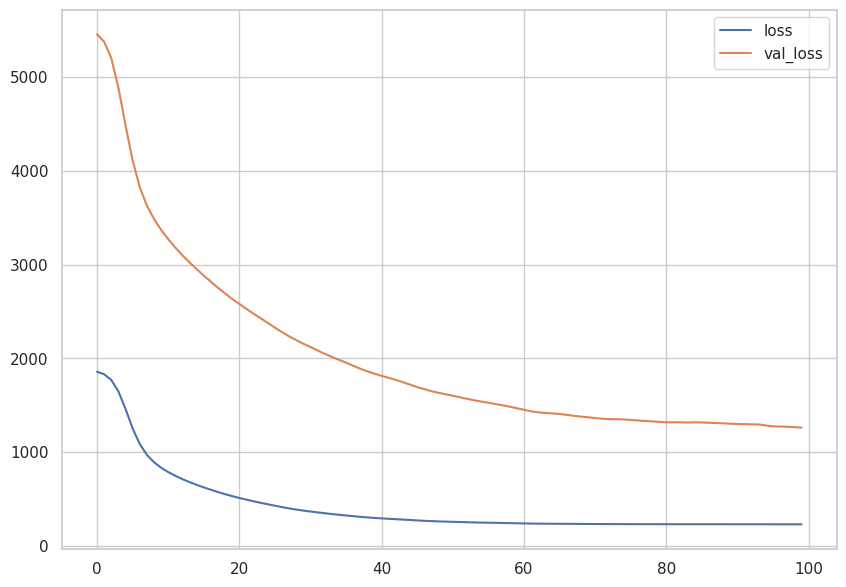

In [27]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

In [28]:
model_2 = Sequential([Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], 1)), Dropout(0.2),
                    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'), BatchNormalization(),
                    LSTM(128, return_sequences=False), Dropout(0.2), Dense(128, activation='relu'), Dense(1)])

model_2.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_2 = model_2.fit(X, y, epochs=100, batch_size=32, validation_split=0.1,
          callbacks=[early_stopping])

target_timestamp = pd.to_datetime(f"{year}-{month:02d}", format='%Y-%m').timestamp()

# Reshape the target timestamp as required by the model
target_timestamp = np.array([[target_timestamp]])

# Make predictions using the model
prediction = model_2.predict(target_timestamp)[0][0]

Epoch 1/100
8/8 [==============================] - 6s 179ms/step - loss: 1859.3497 - val_loss: 5474.9893
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 1843.1927 - val_loss: 5459.6665
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 1824.3542 - val_loss: 5439.1396
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 1801.0272 - val_loss: 5405.0435
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 1768.5707 - val_loss: 5350.9263
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 1714.7877 - val_loss: 5269.6255
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 1624.6726 - val_loss: 5096.4009
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 1502.2384 - val_loss: 4802.9185
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 1286.5601 - val_loss: 4180.9722
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - 

In [29]:
prediction

38.564346

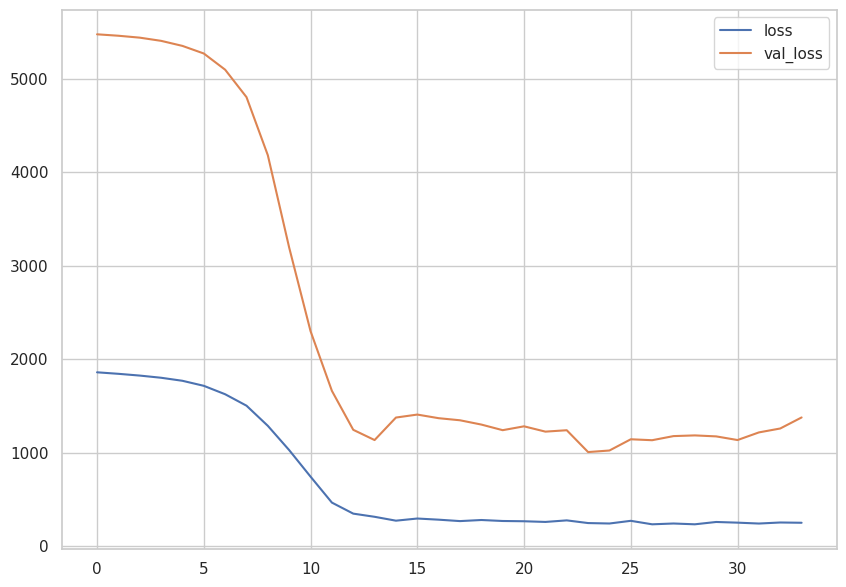

In [30]:
pd.DataFrame(history_2.history).plot(figsize=(10, 7));

In [32]:
model_3 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)), input_shape=(X.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"),
    BatchNormalization(),
    LSTM(128, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1)
])

In [33]:
model_3.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_3 = model_3.fit(X, y, epochs=100, batch_size=32, validation_split=0.1,
          callbacks=[early_stopping])

target_timestamp = pd.to_datetime(f"{year}-{month:02d}", format='%Y-%m').timestamp()

# Reshape the target timestamp as required by the model
target_timestamp = np.array([[target_timestamp]])

# Make predictions using the model
prediction = model_3.predict(target_timestamp)[0][0]

Epoch 1/100
8/8 [==============================] - 5s 127ms/step - loss: 1854.4075 - val_loss: 5479.3604
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 1835.5520 - val_loss: 5460.4326
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 1818.0629 - val_loss: 5444.3623
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 1793.3602 - val_loss: 5414.8926
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 1759.0021 - val_loss: 5402.6035
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 1712.0801 - val_loss: 5318.7744
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 1636.9731 - val_loss: 5128.8857
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 1541.3418 - val_loss: 4999.2842
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 1393.7074 - val_loss: 4946.3706
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - los

In [34]:
prediction

42.270584

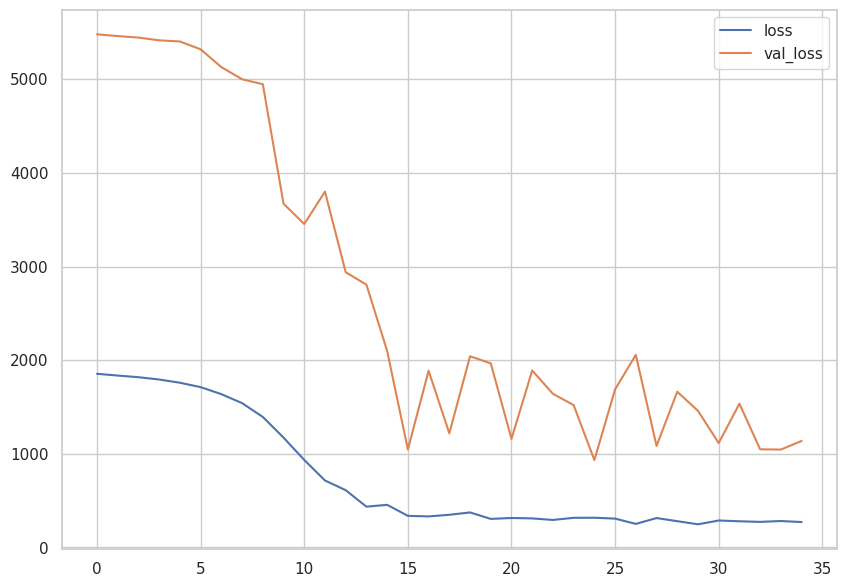

In [35]:
pd.DataFrame(history_3.history).plot(figsize=(10, 7));